# Wigner's semicircle theorem

JAX based GPU computational demon for eigenvalues of random matrices with mean=0 normal elements being distributed by Wigner's distribution:

https://mathworld.wolfram.com/WignersSemicircleLaw.html

https://en.wikipedia.org/wiki/Wigner_semicircle_distribution

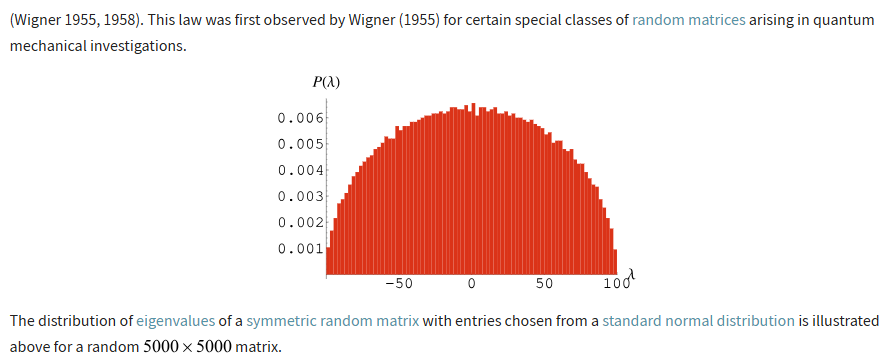

There is certain level of universality to the theorem making it reappear in various areas of research:

https://mathoverflow.net/questions/209731/semicircle-law-universality-elsewhere

Historicaly discovered during quantum systems research, e.g. 1D fermion gas:

https://iris.sissa.it/retrieve/dd8a4bf7-6793-20a0-e053-d805fe0a8cb0/SciPostPhys_2_1_002.pdf

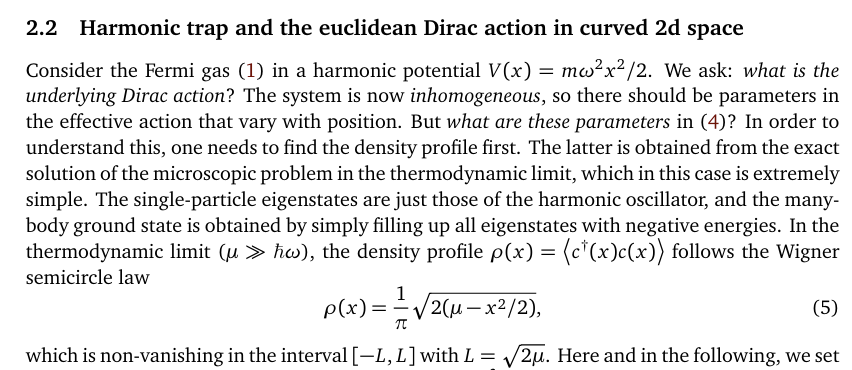


In [9]:
import os
import time

import matplotlib.pyplot as plt

In [10]:
# WSL2 & Memory Configuration (MUST be before import jax)

# PREALLOCATE=false: Prevents JAX from grabbing 90% VRAM at launch.
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# ALLOCATOR=platform: Uses standard CUDA malloc. Slower allocs, but safer for WSL2 sharing.
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import jax
import jax.numpy as jnp

# (Optional) Enable 64-bit precision
# jax.config.update("jax_enable_x64", True)

##### Generate a symmetric matrix where elements have mean 0 and variance 1/n.

In [ ]:
def generate_symmetric_matrix(key, n):
    key, subkey = jax.random.split(key)

    # Generate random normal values with std dev = 1/sqrt(n) -> variance = 1/n
    A = jax.random.normal(subkey, (n, n)) / jnp.sqrt(n)
    
    # Symmetrize: Use upper triangle for both upper and lower parts
    # M_ij = A_ij for i <= j
    # M_ji = A_ij for i < j
    M = jnp.triu(A) + jnp.triu(A, 1).T
    return M

In [12]:
def analyze_matrix_stats(M, name="Matrix"):
    print(f"--- {name} Statistics ---")
    mean = jnp.mean(M)
    var = jnp.var(M)
    print(f"Mean: {mean:.6e} (Expected: 0.0)")
    print(f"Var : {var:.6e} (Expected: {1/M.shape[0]:.6e})\n")

In [ ]:
def plot_distribution(eigens):
    print("Plotting eigenvalue distribution...")
    
    plt.figure(figsize=(10, 6))
    plt.hist(eigens, bins=100, density=True, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f"Eigenvalue Density Distribution (N={len(eigens)})")
    plt.xlabel("Eigenvalue")
    plt.ylabel("Density")
    plt.grid(True, alpha=0.3)
    
    # Add Wigner Semicircle Law (Red upper semiellipse, radius 2, area 1)
    # PDF: f(x) = (1 / (2*pi)) * sqrt(4 - x^2) for |x| <= 2
    x = jnp.linspace(-2, 2, 1000)
    y = (1 / (2 * jnp.pi)) * jnp.sqrt(4 - x**2)
    plt.plot(x, y, color='red', linewidth=2, label='Wigner Semicircle')

    plt.legend()
    plt.show()

In [22]:
def calculate_eigenvalues(N, SEED):
   
    print(f"Generating {N}x{N} symmetric matrix...")
    key = jax.random.PRNGKey(SEED)
    
    start_time = time.time()
    M = generate_symmetric_matrix(key, N)
    M.block_until_ready()  # Block to ensure generation is done
    end_time = time.time()
    
    print(f"Generation took: {end_time - start_time:.4f} seconds\n")
    
    analyze_matrix_stats(M, "Symmetric Matrix")

    print("Calculating eigenvalues...")
    start_time = time.time()

    # eigh is optimized for Hermitian/symmetric matrices
    eigens_jax = jnp.linalg.eigh(M)[0]
    eigens_jax.block_until_ready()  # Block to ensure calculation is done
    end_time = time.time()
    
    print(f"Eigenvalue calculation took: {end_time - start_time:.4f} seconds")
    
    eigens = eigens_jax.tolist()
    print(f"First 5 eigenvalues: {eigens[:5]}\n")

    return eigens

In [23]:
print(f"JAX Default Backend: {jax.default_backend()}")  # this line should print "gpu"

print(f"JAX Devices: {jax.devices()}")
print(f"JAX Backend: {jax.devices()[0].platform.upper()}")
print(f"Device:      {jax.devices()[0].device_kind}\n")

JAX Default Backend: gpu
JAX Devices: [CudaDevice(id=0)]
JAX Backend: GPU
Device:      NVIDIA GeForce RTX 4080



Generating 15000x15000 symmetric matrix...
Generation took: 0.3221 seconds

--- Symmetric Matrix Statistics ---
Mean: -4.831092e-08 (Expected: 0.0)
Var : 6.667135e-05 (Expected: 6.666667e-05)

Calculating eigenvalues...
Eigenvalue calculation took: 4.4502 seconds
First 5 eigenvalues: [-1.9947789907455444, -1.992474913597107, -1.9873837232589722, -1.986885666847229, -1.9861900806427002]

Plotting eigenvalue distribution...


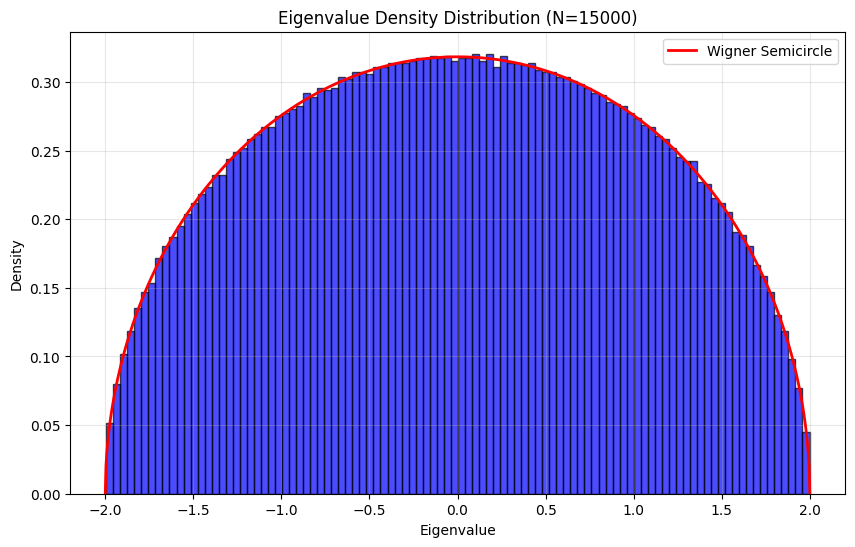

In [25]:
eigens = calculate_eigenvalues(N=15000, SEED=142)
plot_distribution(eigens)